## Best Bubble Tea Location in Toronto

#### This notebook provides codes for the capstone project

#### Part One: Import and combine relevent data from different source
#### Part Two: EDA & Clustering
#### Part Three: Conclustion

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
#WebScraping
# Here, we're just importing both Beautiful Soup and the Requests library
page_link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
# this is the url that we've already determined is safe and legal to scrape from.
page_response = requests.get(page_link, timeout=5).text
# here, we fetch the content from the url, using the requests library
page_content = BeautifulSoup(page_response,'lxml' )

In [3]:
#Make DataFrame
data = []
table_body=page_content.find('tbody')
rows = table_body.find_all('tr')
for row in rows:
    cols=row.find_all('td')
    cols=[x.text.strip() for x in cols]
    data.append(cols)

In [4]:
#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
col_name = ['PostalCode', 'Borough', 'Neighborhood']
df = pd.DataFrame(data, columns = col_name)
df = df[df['Borough'] != 'Not assigned']


In [5]:
df.head()

,PostalCode,Borough,Neighborhood
0,None,None,None
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park


In [6]:
#Check
df.head()
#Drop blank header
df = df.drop(0, axis=0)

In [7]:
dfgroupby = df
#dfgroupby = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()
dfgroupby.head()

,PostalCode,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights


#### If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.

In [8]:
dfgroupby[dfgroupby['Neighborhood'] == 'Not assigned']

,PostalCode,Borough,Neighborhood
9,M7A,Queen's Park,Not assigned


In [9]:
dfgroupby.loc[85,'Neighborhood'] = "Queen's Park"

#### Only Select Borough contains Toronto

In [10]:
dfgroupby[dfgroupby['Borough'].str.contains('Toronto')].head()

,PostalCode,Borough,Neighborhood
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
18,M5B,Downtown Toronto,Ryerson
19,M5B,Downtown Toronto,Garden District
35,M5C,Downtown Toronto,St. James Town


#### Print the number of rows of dataframe.

In [11]:
dfgroupby.shape

(211, 3)

#### Load GeoCoder csv

In [12]:
geo = pd.read_csv("Geospatial_Coordinates.csv")

In [13]:
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
df_joined = dfgroupby.merge(geo, left_on='PostalCode', right_on='Postal Code', how='inner')

#### Del Duplicated postal code col

In [15]:
df_joined = df_joined.drop('Postal Code', axis = 1)

In [16]:
df_joined.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


#### Import Cost of Rent

In [17]:
df_rent = pd.read_csv('Cost of Apartment.csv')

In [18]:
df_rent

,Bachelor,1 Bedroom,2 Bedroom,3 Bedroom +,Total,AVG COST,Neighbourhood
0,**,"1,105","1,316","1,569","1,341",1330.000000,Agincourt/Malvern
1,**,953,"1,248","1,397","1,283",1199.333333,Ajax/Pickering
2,**,"1,169","1,462",**,"1,435",1315.500000,Alderwood
3,**,"1,127","1,347",**,"1,298",1237.000000,Aurora
4,**,"1,163","1,335","1,643","1,286",1380.333333,York Mills
5,**,"1,216","1,346","1,567","1,342",1376.333333,Bathurst Manor
6,"1,615","2,013","3,114",**,"2,301",2563.500000,Bay Street Corridor
7,"1,072","1,381","1,671",**,"1,666",1526.000000,Bayview Village
8,**,"1,389","1,609","1,690","1,580",1562.666667,Hillcrest Village
9,947,"1,125","1,459","1,912","1,277",1498.666667,Bedford Park-Nortown


In [19]:
df_new = df_rent.merge(df_joined, left_on='Neighbourhood', right_on='Neighborhood', how='inner')

In [20]:
df_new.head()

,Bachelor,1 Bedroom,2 Bedroom,3 Bedroom +,Total,AVG COST,Neighbourhood,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,**,"1,169","1,462",**,"1,435",1315.500000,Alderwood,M8W,Etobicoke,Alderwood,43.602414,-79.543484
1,**,"1,163","1,335","1,643","1,286",1380.333333,York Mills,M2L,North York,York Mills,43.757490,-79.374714
2,**,"1,216","1,346","1,567","1,342",1376.333333,Bathurst Manor,M3H,North York,Bathurst Manor,43.754328,-79.442259
3,"1,072","1,381","1,671",**,"1,666",1526.000000,Bayview Village,M2K,North York,Bayview Village,43.786947,-79.385975
4,**,"1,389","1,609","1,690","1,580",1562.666667,Hillcrest Village,M2H,North York,Hillcrest Village,43.803762,-79.363452


### Clustering and Segementing

#### Use geopy library to get the latitude and longitude values of Toronto.

In [21]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Create a map of Toronto with neighborhoods superimposed on top，


In [22]:
# create map of New York using latitude and longitude values
map_tor = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_joined['Latitude'], df_joined['Longitude'], df_joined['Borough'], df_joined['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

#### Define Foursquare Credentials and Version

In [23]:
CLIENT_ID = 'WQ2140I1XRGB3NN4OGJY2SZWCXYCUM41KLT2CVVXZUJ5GPFN' # your Foursquare ID
CLIENT_SECRET = 'DPUGQRNSEA0IEVGCFMX12EVF51DJTQ1Z3NALFTF0MEEQIUIG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WQ2140I1XRGB3NN4OGJY2SZWCXYCUM41KLT2CVVXZUJ5GPFN
CLIENT_SECRET:DPUGQRNSEA0IEVGCFMX12EVF51DJTQ1Z3NALFTF0MEEQIUIG


### create a function to repeat the same process to all the neighborhoods in Manhattan


In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000
tor_venues = getNearbyVenues(names=df_new['Neighborhood'],
                                   latitudes=df_new['Latitude'],
                                   longitudes=df_new['Longitude']
                                  )

Alderwood
York Mills
Bathurst Manor
Bayview Village
Hillcrest Village
Cliffcrest
Dorset Park
Downsview
Flemingdon Park
Forest Hill North
Guildwood
Henry Farm
Humewood-Cedarvale
Ionview
Kennedy Park
Long Branch
Moore Park
Morningside
Regent Park
Mount Dennis
Thistletown
New Toronto
Parkwoods
Riverdale
Roncesvalles
Rouge
Humberlea
Scarborough Village
The Beaches
Thorncliffe Park
The Annex
Victoria Village
West Hill
Weston
Woburn


In [26]:
print(tor_venues.shape)
tor_venues.head()

(390, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alderwood,43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place
1,Alderwood,43.602414,-79.543484,Timothy's Pub,43.600165,-79.544699,Pub
2,Alderwood,43.602414,-79.543484,Toronto Gymnastics International,43.599832,-79.542924,Gym
3,Alderwood,43.602414,-79.543484,Tim Hortons,43.602396,-79.545048,Coffee Shop
4,Alderwood,43.602414,-79.543484,Subway,43.599262,-79.544340,Sandwich Place


#### check how many venues were returned for each neighborhood

In [27]:
tor_venues.groupby('Neighborhood').count().sort_values(by = 'Venue', ascending = False)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Henry Farm,66,66,66,66,66,66
Regent Park,46,46,46,46,46,46
Riverdale,44,44,44,44,44,44
The Annex,24,24,24,24,24,24
Flemingdon Park,21,21,21,21,21,21
Bathurst Manor,19,19,19,19,19,19
Thorncliffe Park,17,17,17,17,17,17
Roncesvalles,15,15,15,15,15,15
New Toronto,15,15,15,15,15,15


In [28]:
print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))

There are 129 uniques categories.


### Analyze Neighborhood

In [29]:
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tor_onehot['Neighborhood'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

,Yoga Studio,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Beer Store,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Cafeteria,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Eastern European Restaurant,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Field,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,General Entertainment,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,Historic Site,History Museum,Hockey Arena,Hotel,Housing Development,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Liquor Store,Luggage Store,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Motel,Movie Theater,Music Venue,Neighborhood,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Pool,Portuguese Restaurant,Pub,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoothie Shop,Spa,Sporting Goods Shop,Sports Bar,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Tennis Court,Theater,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alderwood,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alderwood,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alderwood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alderwood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alderwood,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
tor_grouped = tor_onehot.groupby('Neighborhood').mean().reset_index()
tor_grouped = tor_grouped[tor_grouped['Neighborhood'].isin(['Henry Farm','Regent Park','The Annex' , 'Flemingdon Park','Bathurst Manor', 'Thorncliffe Park','Roncesvalles'])]


In [31]:
tor_grouped

,Neighborhood,Yoga Studio,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Beer Store,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Cafeteria,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Eastern European Restaurant,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Field,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,General Entertainment,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,Historic Site,History Museum,Hockey Arena,Hotel,Housing Development,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Liquor Store,Luggage Store,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Motel,Movie Theater,Music Venue,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Pool,Portuguese Restaurant,Pub,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoothie Shop,Spa,Sporting Goods Shop,Sports Bar,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Tennis Court,Theater,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store
1,Bathurst Manor,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.105263,0.0,0.0,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.0,0.000000,0.0,0.000000,0.000000,0.052632,0.052632,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.052632,0.0,0.000000,0.0,0.000000,0.000000,0.052632,0.052632,0.052632,0.0,0.0,0.0,0.000000,0.0,0.052632,0.000000,0.052632,0.0,0.000000,0.052632,0.0,0.000000,0.000000,0.000000,0.0,0.052632,0.000000,0.052632,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.052632,0.0,0.000000,0.000000,0.000000
6,Flemingdon Park,0.000000,0.000000,0.000000,0.000000,0.095238,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.095238,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.047619,0.000000,0.047619,0.095238,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.047619,0.000000,0.0,0.0,0.047619,0.095238,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.047619,0.047619,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.047619,0.000000,0.047619,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.047619,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
9,Henry Farm,0.000000,0.015152,0.000000,0.000000,0.030303,0.0,0.000000,0.030303,0.015152,0.000000,0.015152,0.000000,0.000000,0.000000,0.015152,0.00000

### Most Common Venues in Each Neiborhood

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tor_grouped['Neighborhood']

for ind in np.arange(tor_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bathurst Manor,Coffee Shop,Shopping Mall,Supermarket,Deli / Bodega,Pet Store,Pharmacy,Pizza Place,Diner,Restaurant,Sandwich Place
6,Flemingdon Park,Gym,Asian Restaurant,Coffee Shop,Beer Store,Sporting Goods Shop,General Entertainment,Italian Restaurant,Japanese Restaurant,Fast Food Restaurant,Discount Store
9,Henry Farm,Clothing Store,Coffee Shop,Fast Food Restaurant,Food Court,Juice Bar,Bus Station,Asian Restaurant,Restaurant,Toy / Game Store,Jewelry Store
21,Regent Park,Coffee Shop,Park,Bakery,Café,Pub,Theater,Mexican Restaurant,Breakfast Spot,Hotel,Farmers Market
23,Roncesvalles,Gift Shop,Breakfast Spot,Coffee Shop,Italian Restaurant,Movie Theater,Dessert Shop,Dog Run,Restaurant,Eastern European Restaurant,Bookstore


In [34]:
# set number of clusters
kclusters = 3

tor_grouped_cluster = tor_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 1, 1])

In [35]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [36]:
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,0,Bathurst Manor,Coffee Shop,Shopping Mall,Supermarket,Deli / Bodega,Pet Store,Pharmacy,Pizza Place,Diner,Restaurant,Sandwich Place
6,0,Flemingdon Park,Gym,Asian Restaurant,Coffee Shop,Beer Store,Sporting Goods Shop,General Entertainment,Italian Restaurant,Japanese Restaurant,Fast Food Restaurant,Discount Store
9,0,Henry Farm,Clothing Store,Coffee Shop,Fast Food Restaurant,Food Court,Juice Bar,Bus Station,Asian Restaurant,Restaurant,Toy / Game Store,Jewelry Store
21,0,Regent Park,Coffee Shop,Park,Bakery,Café,Pub,Theater,Mexican Restaurant,Breakfast Spot,Hotel,Farmers Market
23,2,Roncesvalles,Gift Shop,Breakfast Spot,Coffee Shop,Italian Restaurant,Movie Theater,Dessert Shop,Dog Run,Restaurant,Eastern European Restaurant,Bookstore
26,1,The Annex,Café,Sandwich Place,Coffee Shop,Pizza Place,History Museum,Indian Restaurant,Flower Shop,Pub,Cosmetics Shop,Pharmacy
29,1,Thorncliffe Park,Sandwich Place,Indian Restaurant,Bank,Burger Joint,Liquor Store,Supermarket,Pizza Place,Pharmacy,Yoga Studio,Park


In [37]:

tor_merged = df_joined

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood',how = 'inner')

tor_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Café,Pub,Theater,Mexican Restaurant,Breakfast Spot,Hotel,Farmers Market
24,M3C,North York,Flemingdon Park,43.725900,-79.340923,0,Gym,Asian Restaurant,Coffee Shop,Beer Store,Sporting Goods Shop,General Entertainment,Italian Restaurant,Japanese Restaurant,Fast Food Restaurant,Discount Store
45,M3H,North York,Bathurst Manor,43.754328,-79.442259,0,Coffee Shop,Shopping Mall,Supermarket,Deli / Bodega,Pet Store,Pharmacy,Pizza Place,Diner,Restaurant,Sandwich Place
48,M4H,East York,Thorncliffe Park,43.705369,-79.349372,1,Sandwich Place,Indian Restaurant,Bank,Burger Joint,Liquor Store,Supermarket,Pizza Place,Pharmacy,Yoga Studio,Park
56,M2J,North York,Henry Farm,43.778517,-79.346556,0,Clothing Store,Coffee Shop,Fast Food Restaurant,Food Court,Juice Bar,Bus Station,Asian Restaurant,Restaurant,Toy / Game Store,Jewelry Store


In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]



In [39]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], tor_merged['Neighborhood'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [46]:
kclusters=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], tor_merged['Neighborhood'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

### Exam Cluster

In [40]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, tor_merged.columns[[2] + list(range(5, tor_merged.shape[1]))]].merge(df_rent, right_on='Neighbourhood', left_on='Neighborhood', how='left')

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Bachelor,1 Bedroom,2 Bedroom,3 Bedroom +,Total,AVG COST,Neighbourhood
0,Regent Park,0,Coffee Shop,Park,Bakery,Café,Pub,Theater,Mexican Restaurant,Breakfast Spot,Hotel,Farmers Market,975,"1,282","1,647","1,828","1,285",1585.666667,Regent Park
1,Flemingdon Park,0,Gym,Asian Restaurant,Coffee Shop,Beer Store,Sporting Goods Shop,General Entertainment,Italian Restaurant,Japanese Restaurant,Fast Food Restaurant,Discount Store,**,"1,145","1,308","1,496","1,255",1316.333333,Flemingdon Park
2,Bathurst Manor,0,Coffee Shop,Shopping Mall,Supermarket,Deli / Bodega,Pet Store,Pharmacy,Pizza Place,Diner,Restaurant,Sandwich Place,**,"1,216","1,346","1,567","1,342",1376.333333,Bathurst Manor
3,Henry Farm,0,Clothing Store,Coffee Shop,Fast Food Restaurant,Food Court,Juice Bar,Bus Station,Asian Restaurant,Restaurant,Toy / Game Store,Jewelry Store,**,"1,388","1,716","1,798","1,625",1634.000000,Henry Farm


In [41]:
tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[2] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Thorncliffe Park,1,Sandwich Place,Indian Restaurant,Bank,Burger Joint,Liquor Store,Supermarket,Pizza Place,Pharmacy,Yoga Studio,Park
131,The Annex,1,Café,Sandwich Place,Coffee Shop,Pizza Place,History Museum,Indian Restaurant,Flower Shop,Pub,Cosmetics Shop,Pharmacy


In [42]:
tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[2] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
135,Roncesvalles,2,Gift Shop,Breakfast Spot,Coffee Shop,Italian Restaurant,Movie Theater,Dessert Shop,Dog Run,Restaurant,Eastern European Restaurant,Bookstore


In [55]:
import seaborn as sns

C:\Users\Jerry Yan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


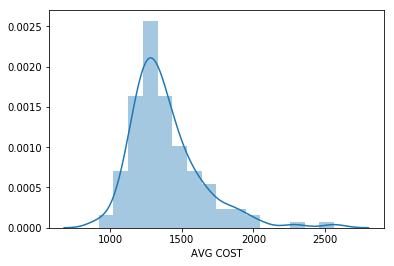

In [57]:
sns.distplot(df_rent['AVG COST'])

In [59]:
df_rent['AVG COST'].mean()

1387.6266666880003

### Conclusion - Shop Selection

#### By Kmeans clustering, we are able to group similar neiborhoods together. After doing that, we joined rent table with clustering resuilts. The combination of these two dataframe is able to give us both venue information as well as average rent per neiborhood

#### With close examination, we are able to narrow our selection to cluster 1. The cluster that has relatively more resturant. Within Cluster 1, when we consider our requirement of higher than average living cost(rent). We are able to further narrow down to the two optimal selections.

#### Selection1 : Regent Park with average cost of living CAD1585
#### Selection2 : Henry Farm with average cost of living CAD 1634

#### Out of two selection, Herny Farm has more asian resturant(7th Most Common Venue is Japanses Resturant).
#### With our assumption that asian food ans bubble tea are supplementary products. We should therefore choose Hernry Farm as it has more asian resturant.